### 0. Imports and Variable Setup

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
from functions import util
import os
import hopsworks

country="sweden"
city = "solna"
street = "solna-rasundavagen-107"
aqicn_url="https://api.waqi.info/feed/@13988"

In [2]:

# Get the API key from GitHub Secrets
HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')

In [3]:
# Connect to Hopsworks Project and Features Store
project = hopsworks.login(project="ID2223LAB1KTH")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583


Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

## 4. Batch Inference

In [5]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today = today.replace(hour=0, minute=0, second=0, microsecond=0)

today

datetime.datetime(2024, 11, 22, 0, 0)

In [6]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.554429E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.45s) 


,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2024-11-22 00:00:00+00:00,-4.898,-6.698,0.0,17.639999,258.300720
1,2024-11-23 00:00:00+00:00,-1.548,-6.648,0.0,16.919998,253.204987
2,2024-11-24 00:00:00+00:00,5.600,-3.998,7.9,30.960001,179.862122
3,2024-11-25 00:00:00+00:00,10.250,5.800,8.5,25.071096,202.403854
4,2024-11-26 00:00:00+00:00,6.400,2.850,0.5,15.379206,208.870087
5,2024-11-27 00:00:00+00:00,4.350,2.250,0.8,16.099689,36.358643
6,2024-11-28 00:00:00+00:00,5.050,2.150,1.3,12.261158,9.181294


In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_max','temperature_2m_min','precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
0,2024-11-22 00:00:00+00:00,-4.898,-6.698,0.0,17.639999,258.300720,14.671844
1,2024-11-23 00:00:00+00:00,-1.548,-6.648,0.0,16.919998,253.204987,15.974810
2,2024-11-24 00:00:00+00:00,5.600,-3.998,7.9,30.960001,179.862122,38.872013
3,2024-11-25 00:00:00+00:00,10.250,5.800,8.5,25.071096,202.403854,21.269487
4,2024-11-26 00:00:00+00:00,6.400,2.850,0.5,15.379206,208.870087,30.196804
5,2024-11-27 00:00:00+00:00,4.350,2.250,0.8,16.099689,36.358643,27.416012
6,2024-11-28 00:00:00+00:00,5.050,2.150,1.3,12.261158,9.181294,25.578766


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[us, UTC]
 1   temperature_2m_max           7 non-null      float32            
 2   temperature_2m_min           7 non-null      float32            
 3   precipitation_sum            7 non-null      float32            
 4   wind_speed_10m_max           7 non-null      float32            
 5   wind_direction_10m_dominant  7 non-null      float32            
 6   predicted_pm25               7 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(6)
memory usage: 352.0 bytes


In [12]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data = batch_data.drop(columns=['temperature_2m_max','temperature_2m_min','precipitation_sum','wind_speed_10m_max','wind_direction_10m_dominant'])
batch_data

,date,predicted_pm25
0,2024-11-22 00:00:00+00:00,14.671844
1,2024-11-23 00:00:00+00:00,15.974810
2,2024-11-24 00:00:00+00:00,38.872013
3,2024-11-25 00:00:00+00:00,21.269487
4,2024-11-26 00:00:00+00:00,30.196804
5,2024-11-27 00:00:00+00:00,27.416012
6,2024-11-28 00:00:00+00:00,25.578766


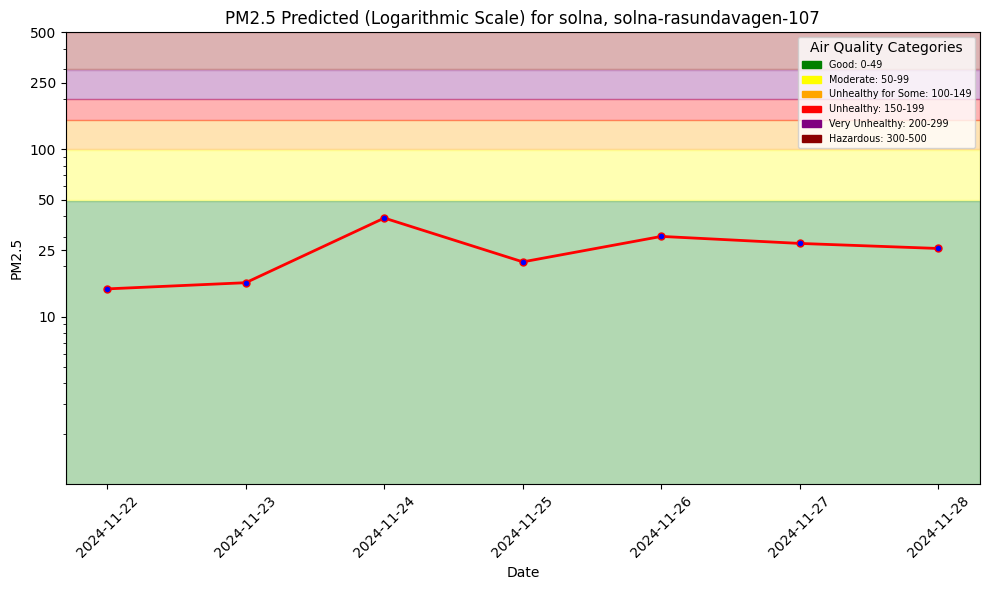

In [13]:
file_path = images_dir + "/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['date'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data)

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1170583/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f0de1b3ec10>, None)

In [16]:
air_quality_fg = fs.get_feature_group(
    name='stockholm_air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.50s) 


,date,pm25,pm10
0,2023-01-23 00:00:00+00:00,30,6
1,2023-12-20 00:00:00+00:00,14,3
2,2022-11-01 00:00:00+00:00,17,8
3,2023-03-15 00:00:00+00:00,13,20
4,2023-07-27 00:00:00+00:00,9,4
...,...,...,...
580,2024-11-23 00:00:00+00:00,8,4
581,2024-11-24 00:00:00+00:00,10,5
582,2024-11-25 00:00:00+00:00,11,6
583,2024-11-27 00:00:00+00:00,4,4


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  batch_data[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-22 00:00:00+00:00,14.671844,3
1,2024-11-23 00:00:00+00:00,15.974810,8
2,2024-11-24 00:00:00+00:00,38.872013,10
3,2024-11-25 00:00:00+00:00,21.269487,11
4,2024-11-26 00:00:00+00:00,30.196804,8
5,2024-11-27 00:00:00+00:00,27.416012,4


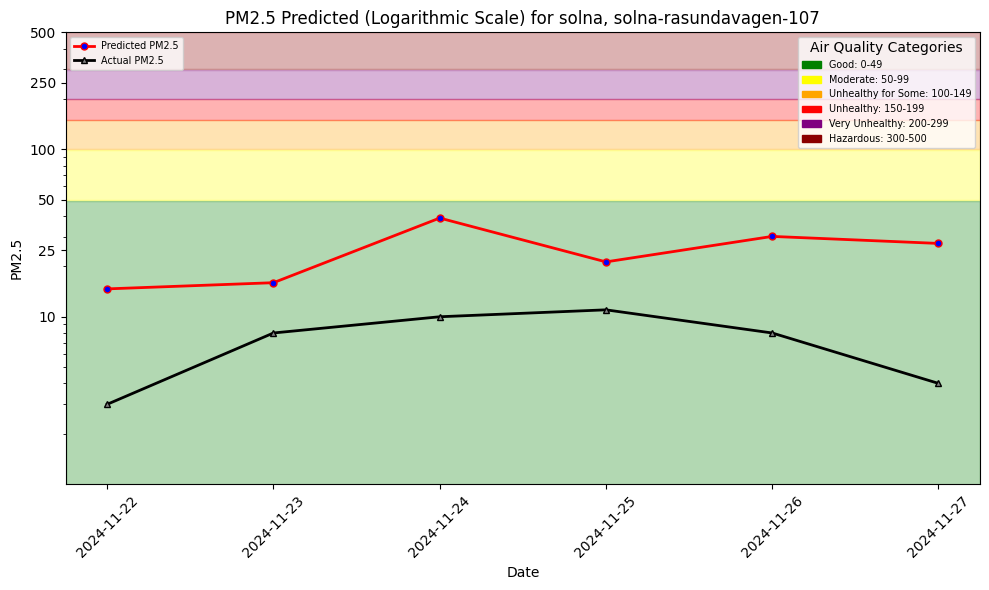

In [18]:

# Define the directory where you want to save the image
images_dir = "./dashboard"  # You can change this path as needed
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Save the figure to the images directory
file_path = os.path.join(images_dir, "pm25_hindcast_5_days.png")
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()